In [1]:
# libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

### utils functions

In [2]:
from math import pi, sqrt, exp


def gauss(size, sigma):
    kernel = list(map(
        lambda x: 1 / (sqrt(2 * pi) * sigma) * exp(-x ** 2 / (2 * sigma ** 2)),
        range(-size, size + 1)
    ))
    return np.array(kernel) / sum(kernel)


def gaussdx(size, sigma):
    kernel = list(map(
        lambda x: -1 / (sqrt(2 * pi) * sigma ** 3) * x * exp(-x ** 2 / (2 * sigma ** 2)),
        range(-size, size + 1)
    ))
    return np.array(kernel) / np.sum(np.abs(kernel))


def convert_to_2D(kernel):
    size = (len(kernel) - 1) // 2
    kernel2d = np.zeros((2 * size + 1, 2 * size + 1))
    kernel2d[size, :] = kernel  # kernel should be in the middle row of square matrix
    return kernel2d


def show_images(images, titles=None):
    for idx, im in enumerate(images):
        plt.imshow(im, cmap='gray')
        if titles is not None: plt.title(titles[idx])
        plt.show()


def flip(kernel):
    return kernel.reshape(-1)[::-1].reshape((kernel.shape))


def convolve(src, kernel):
    return cv2.filter2D(src, -1, flip(kernel))


def convolve_more_kernels(src, kernels):
    src_copy = np.copy(src)
    for kernel in kernels:
        src_copy = convolve(src_copy, kernel)
    return src_copy


def get_image_derivatives(I, size, sigma):
    G = convert_to_2D(gauss(size, sigma))
    D = convert_to_2D(gaussdx(size, sigma))
    Ix = convolve_more_kernels(I, [G.T, D])
    Iy = convolve_more_kernels(I, [D.T, G])
    return Ix, Iy


def gradient_magnitude(I, sigma, kernel_size):
    Ix, Iy = get_image_derivatives(I, kernel_size, sigma)
    magnitude = np.sqrt(Ix ** 2 + Iy ** 2)
    gradient = np.arctan2(Iy, Ix)
    return magnitude, gradient


def test_image():
    test = np.zeros((11, 11))
    test[5, :] = 5
    test[4, :] = 5
    test[3, :] = 5
    test[6, :] = 2
    test[7, :] = 1
    test[2, :] = 2
    test[1, :] = 1
    return test


# 2) Canny
### A) findedges

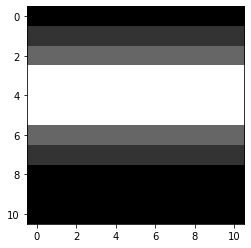

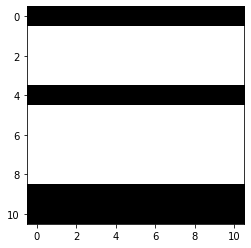

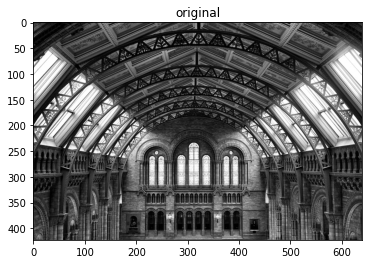

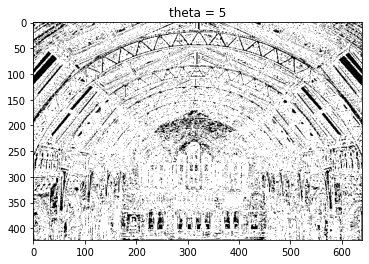

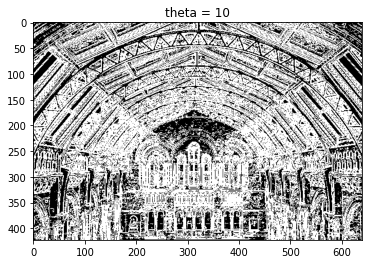

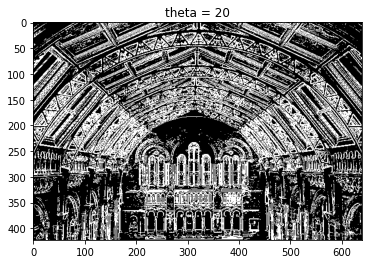

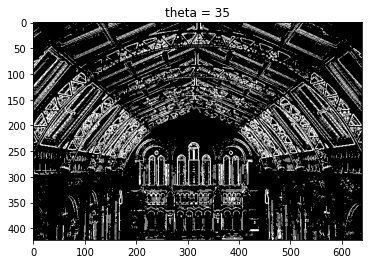

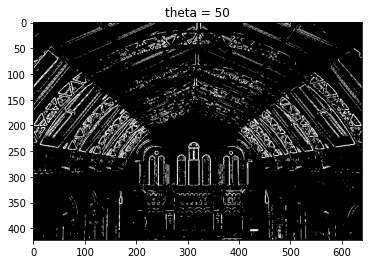

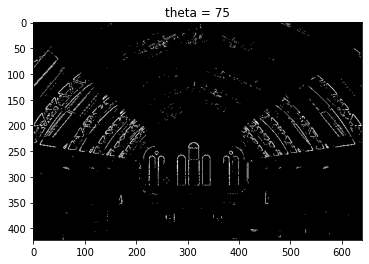

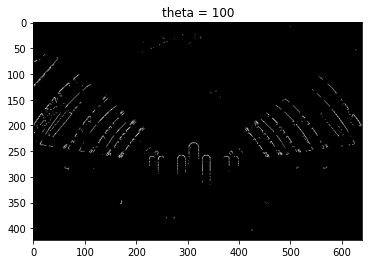

In [3]:

def find_edges(I, sigma, theta, kernel_size=1):
    I_mag, _ = gradient_magnitude(I, sigma, kernel_size)
    Ie = np.zeros(I.shape)
    Ie[I_mag >= theta] = 1
    return Ie


I = cv2.imread('images/museum.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I = I.astype(float)

thetas = [5, 10, 20, 35, 50, 75, 100]
images_edges = [find_edges(I, 0.5, theta) for theta in thetas]

test = test_image()
show_images([test, find_edges(test, 1, 0.1)])
show_images([I] + images_edges, titles=['original'] + [f'theta = {theta}' for theta in thetas])

### B) non-maxima supression

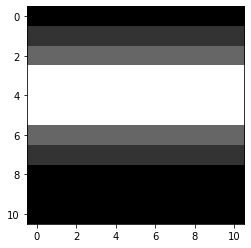

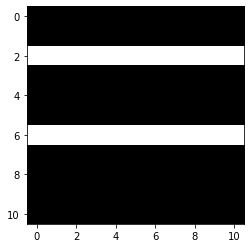

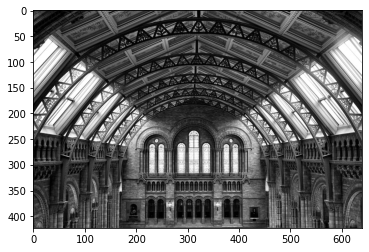

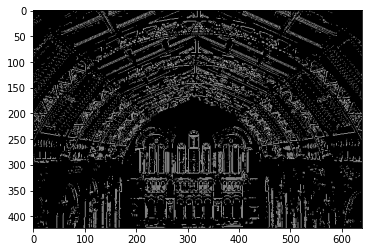

In [4]:
def non_maxima_supression(I_mag, I_dir, I_edges):
    I_dir = I_dir * 180 / pi
    I_dir[I_dir < 0] += 180

    I_nms = np.zeros(I_mag.shape)

    for i in range(I_mag.shape[0]):
        for j in range(I_mag.shape[1]):
            if I_edges[i, j] == 0:
                continue
            direction = I_dir[i, j]
            magnitude = I_mag[i, j]
            try:
                if (direction >= 0 and I_dir[i, j] < 22.5) or (direction >= 157.5 and direction <= 180):
                    if magnitude > I_mag[i, j - 1] and magnitude > I_mag[i, j + 1]:
                        I_nms[i, j] = 255
                elif (direction >= 22.5 and direction < 67.5):
                    if magnitude > I_mag[i + 1, j - 1] and magnitude > I_mag[i - 1, j + 1]:
                        I_nms[i, j] = 255
                elif (direction >= 67.5 and direction < 112.5):
                    if magnitude > I_mag[i + 1, j] and magnitude > I_mag[i - 1, j]:
                        I_nms[i, j] = 255
                elif (direction >= 112.5 and direction < 157.5):
                    if magnitude > I_mag[i + 1, j + 1] and magnitude > I_mag[i - 1, j - 1]:
                        I_nms[i, j] = 255
            except Exception:
                pass
    return I_nms


def canny_without_hysterises(I, sigma, theta, kernel_size):
    I_mag, I_dir = gradient_magnitude(I, sigma, kernel_size)
    I_edges = find_edges(I, sigma, theta, kernel_size)
    return non_maxima_supression(I_mag, I_dir, I_edges)


#TODO: threshold
I = cv2.imread('images/museum.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I = I.astype(float)

test = test_image()
show_images([test, canny_without_hysterises(test, 1, 2, 1), I, canny_without_hysterises(I, 0.5, 35, 1)])
